In [1]:
import model_torch
import modules_torch
import _utils_torch
from Preprocessing import *
from _utils_torch import *
import loss

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print(torch.cuda.is_available())

True


In [3]:
data_dir = '../Data'
data_list = os.listdir(data_dir)

S1_list = []
S2_list = []
for item in data_list:
    if 'S1' in item:
        S1_list.append(item)
    elif 'S2' in item:
        S2_list.append(item)

In [4]:
train_data_list = S1_list[:5] + S2_list[:5]
test_data_list = S1_list[5:] + S2_list[5:]

In [5]:
label = 1

X_test = []
Y_test = []
for item in tqdm(test_data_list):
    folder = '../Data/' + item 
    items = glob.glob(folder + '/*.nii')
    for file in items:
        if 'label' in file:
            sam_mask = sitk.ReadImage(file)
            sam_mask = sitk.GetArrayFromImage(sam_mask).astype(np.uint8)
            sam_mask[sam_mask!=label] = 0
            sam_mask[sam_mask==label] = 1
            for _slice in range(len(sam_mask)):
                slice_mask = resize(sam_mask[_slice,...],(512,512),anti_aliasing=False,preserve_range=True,order=0)
                Y_test.append(slice_mask)
        else:
            sam_img = sitk.ReadImage(file)
            sam_img = sitk.GetArrayFromImage(sam_img)
            sam_img = normalize_dcm(sam_img).astype(np.float32)
            for _slice in range(len(sam_img)):
                slice_img = resize(sam_img[_slice,...],(512,512),anti_aliasing=True,preserve_range=True,order=0)
                X_test.append(slice_img)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
print(X_test.shape, X_test.min(), X_test.max(), X_test.dtype)
print(Y_test.shape, Y_test.min(), Y_test.max(), Y_test.dtype)

(700, 512, 512) 0.0 1.0 float32
(700, 512, 512) 0 1 uint8


In [7]:
h_params=EasyDict()
h_params.gpu_num=0
h_params.seed=42
h_params.batch_size=32
h_params.model_name = "./output/model_final.pth"
h_params.model_save_base = os.path.join(os.getcwd(),"./output/train_log")
device = torch.device(f"cuda:{h_params.gpu_num}" if torch.cuda.is_available() else 'cpu')

In [8]:
val_transform = A.Compose([
    A.Resize(width=512, height=512),
    ToTensorV2(),
], p=1)

In [9]:
test_dataset = custom_dataset(img=X_test,
                              mask=Y_test,
                              transform=val_transform)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=h_params.batch_size,
                             shuffle=False)

In [10]:
model = model_torch.Unet(
    encoder_name='resnet34',
    encoder_depth=5,
    encoder_weights=None,
    in_channels=1, 
    classes=1,
    activation=None,
    )
model = model.to(device)
check_point_path = h_params.model_name
check_point = torch.load(check_point_path)
model.load_state_dict(check_point)

<All keys matched successfully>

In [11]:
x_test = []
y_test = []
pred_test = []

model.eval()
with torch.no_grad():
    for data in tqdm(test_dataloader,total=len(test_dataloader),position=0,desc='Test',colour='green'):
        
        image = data['image'].to(device, dtype=torch.float)
        target = data['mask'].to(device, dtype=torch.long)
        
        y_pred = model(image).sigmoid()

        for idx in range(len(image)):
            idx_image = image[idx]
            idx_target = target[idx]
            idx_pred = y_pred[idx]
            x_test.append(idx_image.cpu().numpy().astype(np.float16)[0,...])
            y_test.append(idx_target.cpu().numpy())
            pred_test.append(idx_pred.cpu().numpy()[0,...])
        
        
x_test = np.array(x_test)
y_test = np.array(y_test)
pred_test = np.array(pred_test)

pred_test[pred_test>.5] = 1
pred_test[pred_test<=.5] = 0

print(x_test.shape, x_test.min(), x_test.max(), x_test.dtype)
print(y_test.shape, y_test.min(), y_test.max(), y_test.dtype)
print(pred_test.shape, pred_test.min(), pred_test.max(), pred_test.dtype)

Test:   0%|          | 0/22 [00:00<?, ?it/s]

(700, 512, 512) 0.0 1.0 float16
(700, 512, 512) 0 1 int64
(700, 512, 512) 0.0 1.0 float32


In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score

def dice_coefficient(y_true, y_pred, num_class=1):
    y_true[y_true!=num_class] = 0
    y_true[y_true==num_class] = 1
    y_pred[y_pred!=num_class] = 0
    y_pred[y_pred==num_class] = 1
    dice_score = f1_score(y_true.flatten(), y_pred.flatten(), average=None, zero_division=1)
    return dice_score

def precision_recall(y_true, y_pred, num_class=1):
    y_true[y_true!=num_class] = 0
    y_true[y_true==num_class] = 1
    y_pred[y_pred!=num_class] = 0
    y_pred[y_pred==num_class] = 1
    precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, zero_division=1)
    recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, zero_division=1)
    return precision, recall

In [13]:
sum_dice = []
sum_prec = []
sum_rec = []
for _slice in range(len(y_test)):
    dice = dice_coefficient(y_test[_slice,...].copy(),
                            pred_test[_slice,...].copy())
    prec, rec = precision_recall(y_test[_slice,...].copy(),
                                 pred_test[_slice,...].copy())
    dice = np.round(dice[0], 5)
    prec = np.round(prec[0], 5)
    rec = np.round(rec[0], 5)
    sum_dice.append(dice)
    sum_prec.append(prec)
    sum_rec.append(rec)
sum_dice = np.array(sum_dice)
sum_prec = np.array(sum_prec)
sum_rec = np.array(sum_rec)
print('Mean dsc:', np.nanmean(sum_dice))
print('STD dsc:', np.nanstd(sum_dice))
print('Mean precision:', np.nanmean(sum_prec))
print('STD precision:', np.nanstd(sum_prec))
print('Mean recall:', np.nanmean(sum_rec))
print('STD recall:', np.nanstd(sum_rec))
print('\n')

Mean dsc: 0.9995969285714286
STD dsc: 0.0010935067420450412
Mean precision: 0.9996288000000001
STD precision: 0.0011845825014987939
Mean recall: 0.9995669857142858
STD recall: 0.0016981900195952924




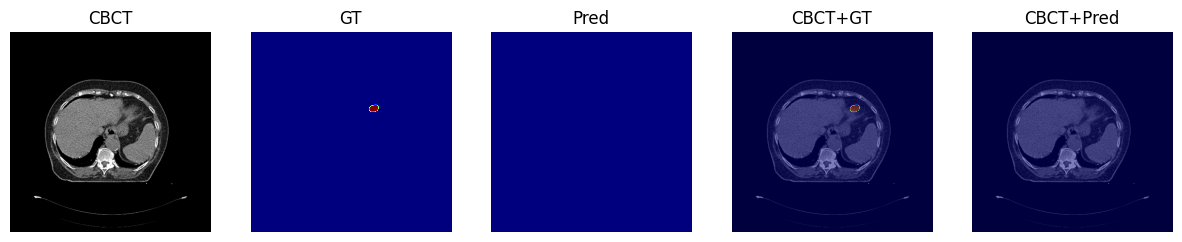

GT: 0 1
Pred: 0.0 0.0


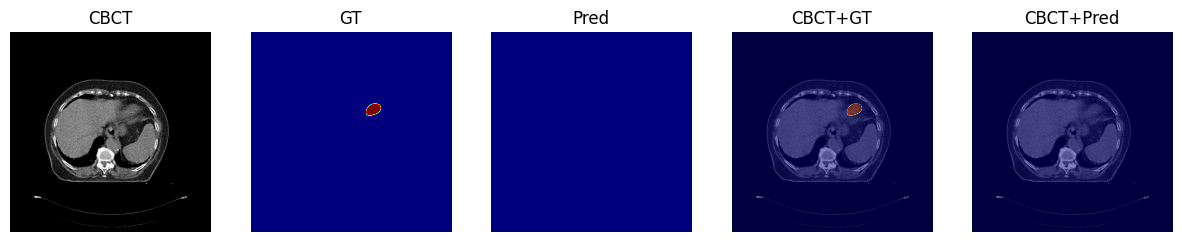

GT: 0 1
Pred: 0.0 0.0


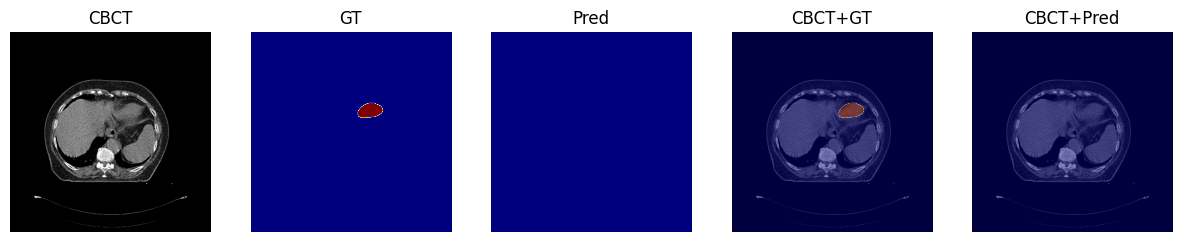

GT: 0 1
Pred: 0.0 0.0


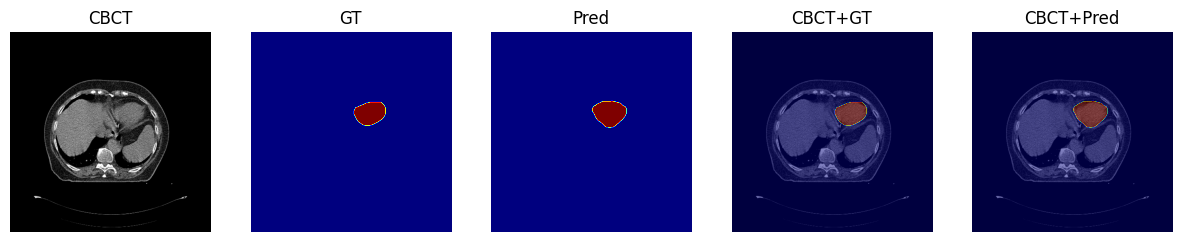

GT: 0 1
Pred: 0.0 1.0


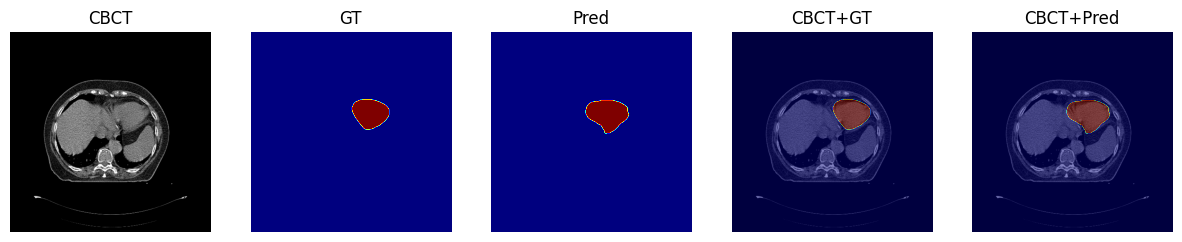

GT: 0 1
Pred: 0.0 1.0


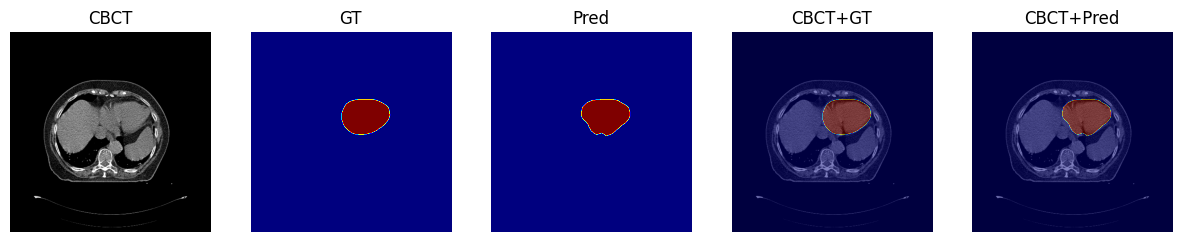

GT: 0 1
Pred: 0.0 1.0


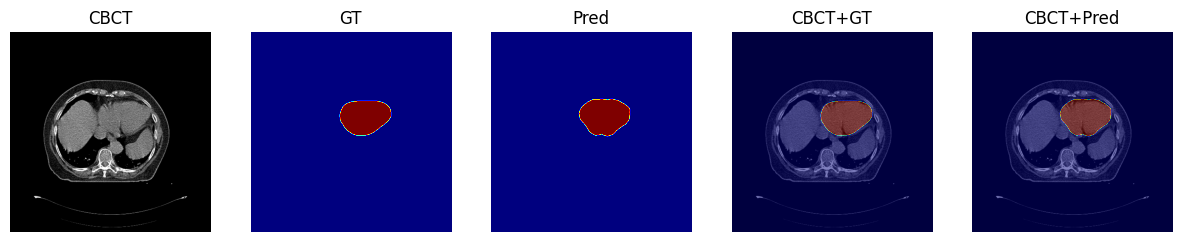

GT: 0 1
Pred: 0.0 1.0


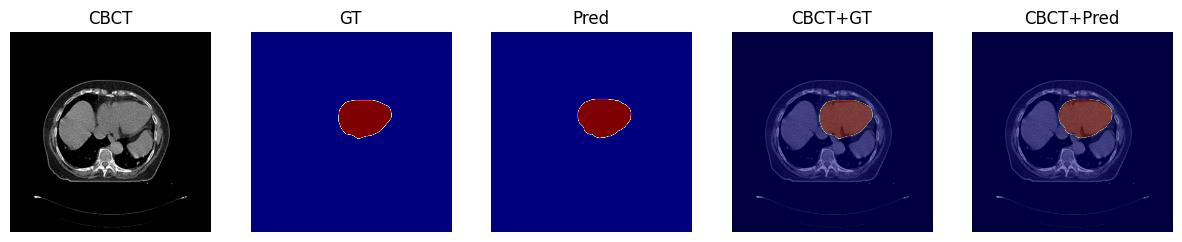

GT: 0 1
Pred: 0.0 1.0


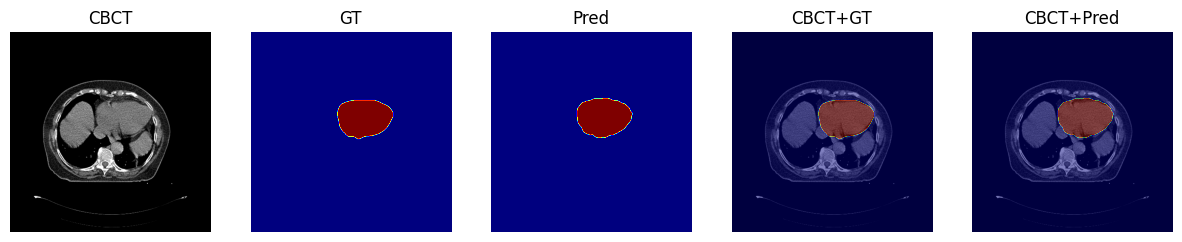

GT: 0 1
Pred: 0.0 1.0


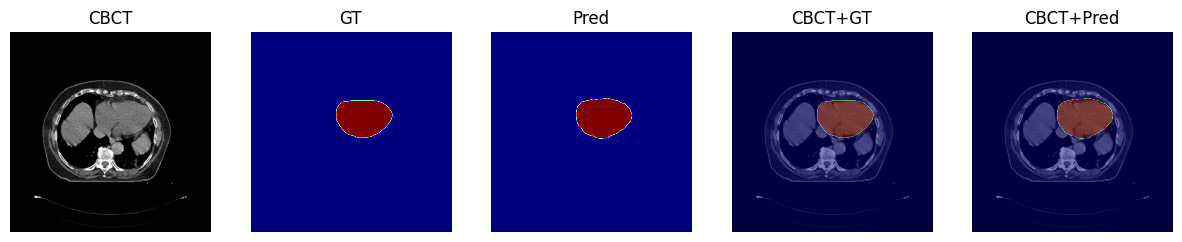

GT: 0 1
Pred: 0.0 1.0


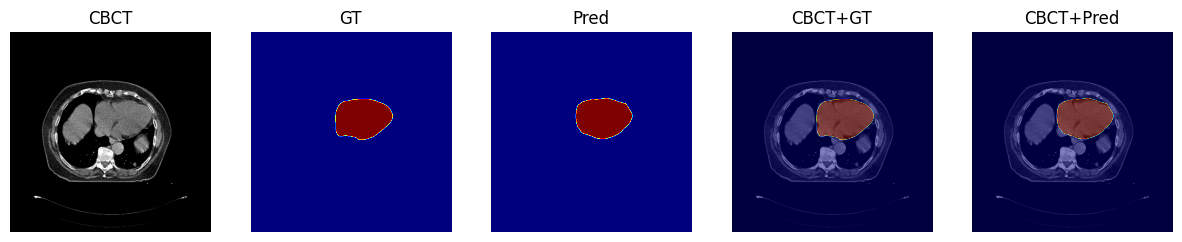

GT: 0 1
Pred: 0.0 1.0


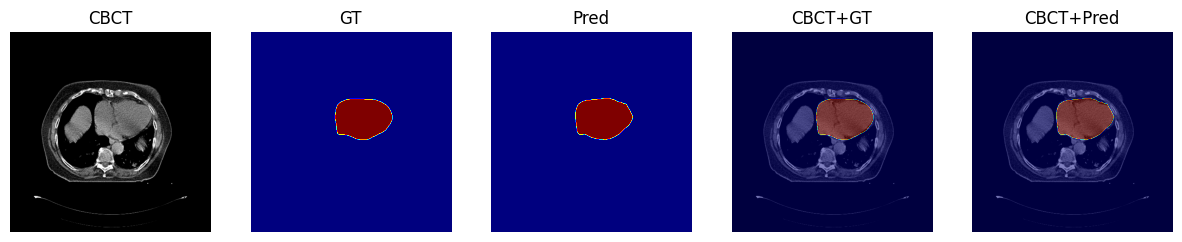

GT: 0 1
Pred: 0.0 1.0


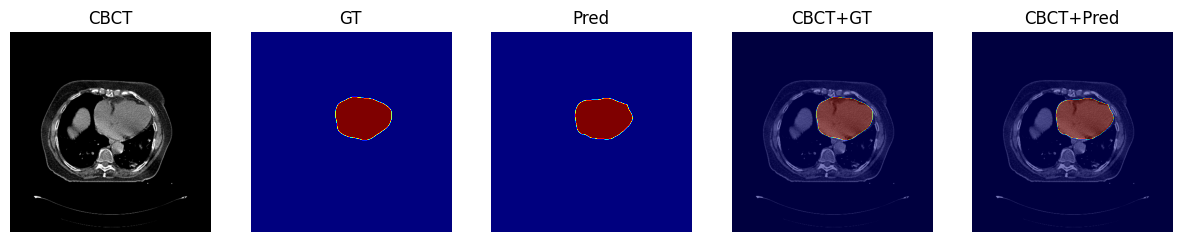

GT: 0 1
Pred: 0.0 1.0


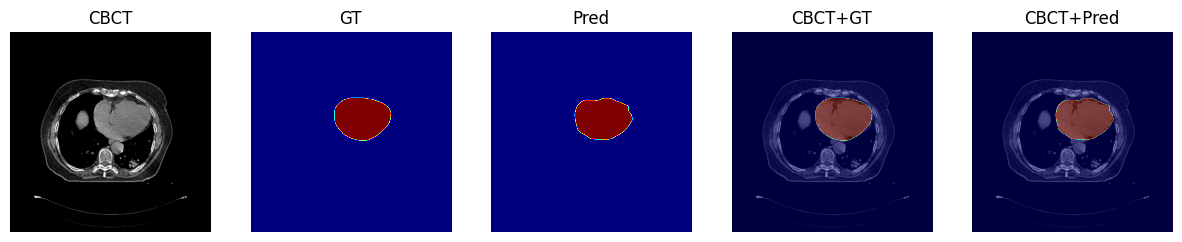

GT: 0 1
Pred: 0.0 1.0


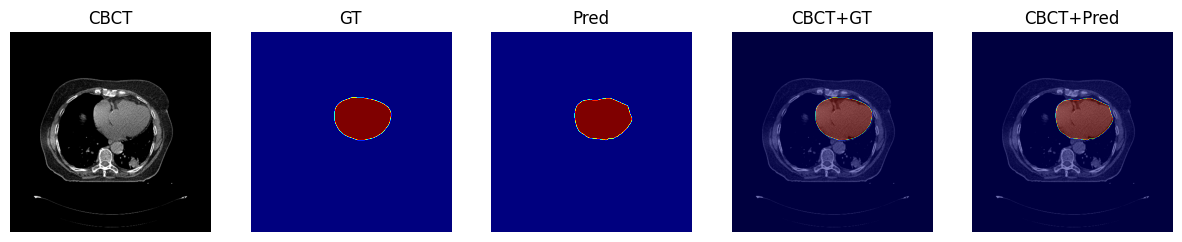

GT: 0 1
Pred: 0.0 1.0


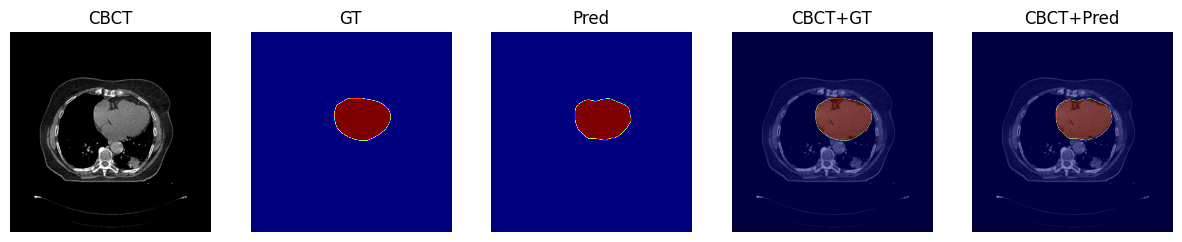

GT: 0 1
Pred: 0.0 1.0


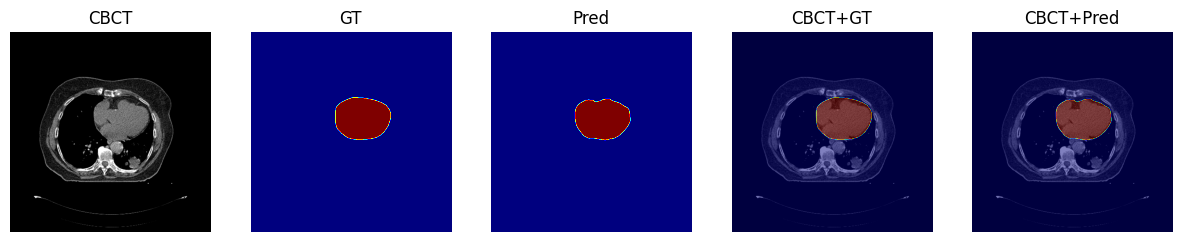

GT: 0 1
Pred: 0.0 1.0


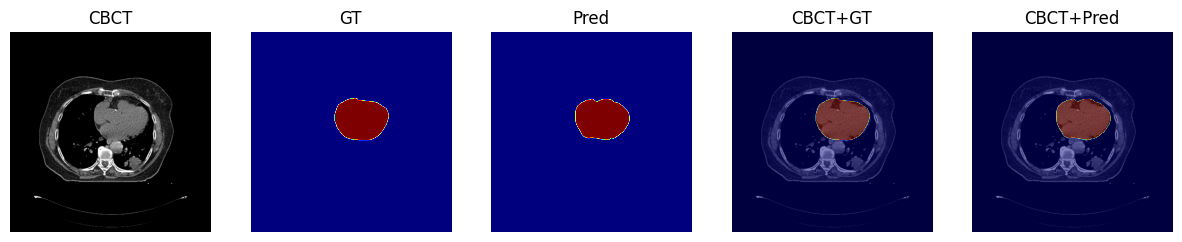

GT: 0 1
Pred: 0.0 1.0


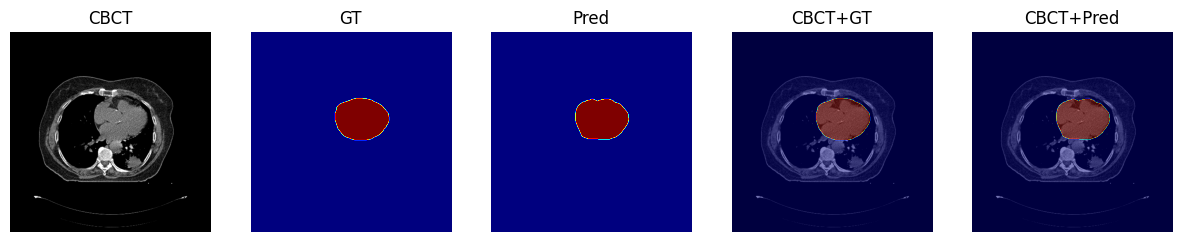

GT: 0 1
Pred: 0.0 1.0


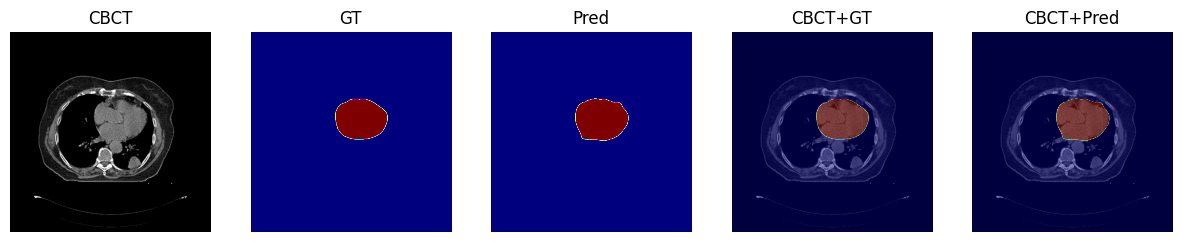

GT: 0 1
Pred: 0.0 1.0


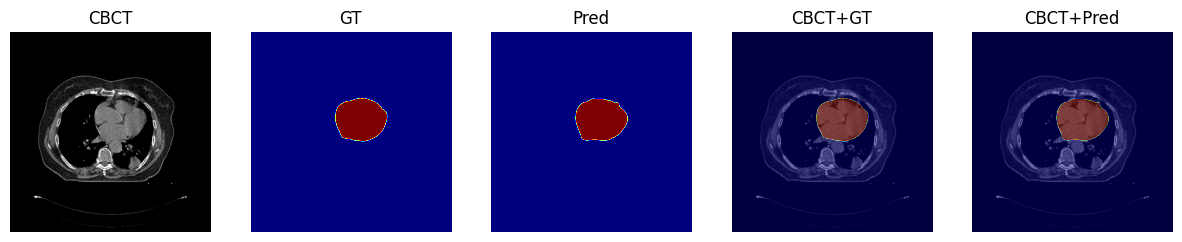

GT: 0 1
Pred: 0.0 1.0


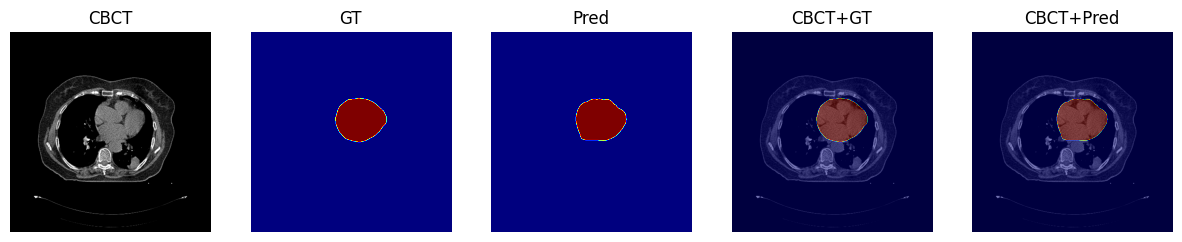

GT: 0 1
Pred: 0.0 1.0


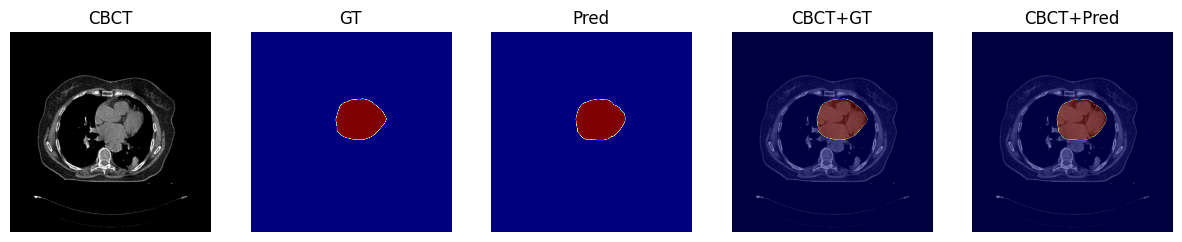

GT: 0 1
Pred: 0.0 1.0


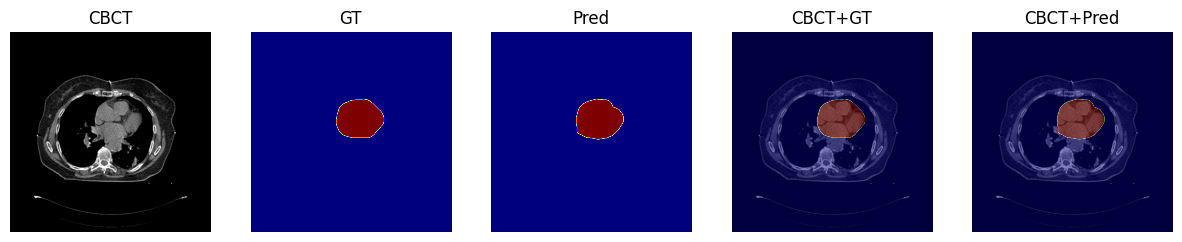

GT: 0 1
Pred: 0.0 1.0


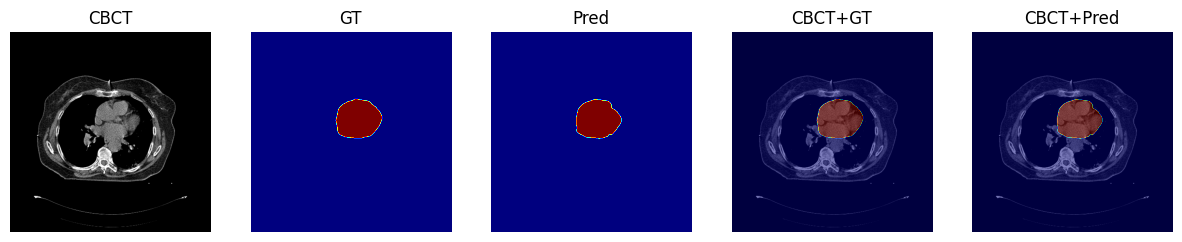

GT: 0 1
Pred: 0.0 1.0


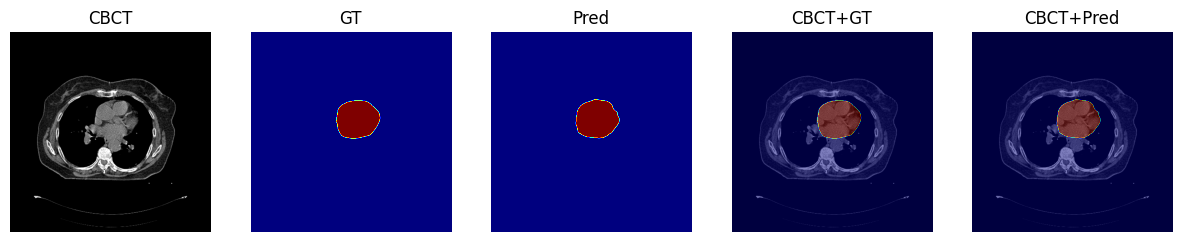

GT: 0 1
Pred: 0.0 1.0


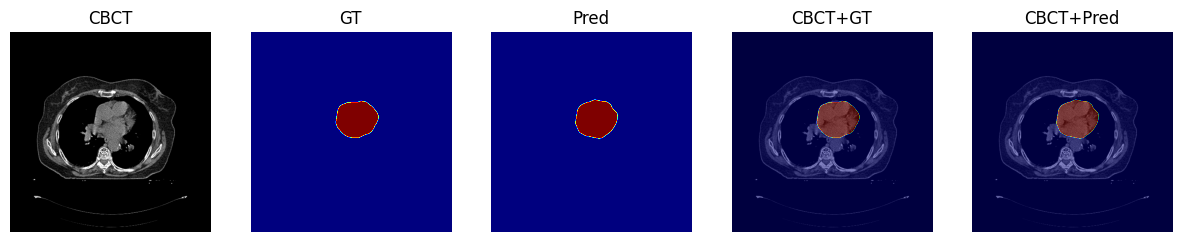

GT: 0 1
Pred: 0.0 1.0



KeyboardInterrupt



In [14]:
for _slice in range(len(x_test)):
    image = x_test[_slice,...]
    target = y_test[_slice,...]
    prediction = pred_test[_slice,...]

    if prediction.max()==0 and target.max()==0:
        continue
    
    plt.figure(figsize=(15,15))
    plt.subplot(151)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title('CBCT')
    plt.subplot(152)
    plt.imshow(target, cmap='jet')
    plt.axis('off')
    plt.title('GT')
    plt.subplot(153)
    plt.imshow(prediction, cmap='jet')
    plt.axis('off')
    plt.title('Pred')
    plt.subplot(154)
    plt.imshow(image, cmap='gray')
    plt.imshow(target, cmap='jet', alpha=.5)
    plt.title('CBCT+GT')
    plt.axis('off')
    plt.subplot(155)
    plt.imshow(image, cmap='gray')
    plt.imshow(prediction, cmap='jet', alpha=.5)
    plt.axis('off')
    plt.title('CBCT+Pred')
    plt.show()

    print('GT:', target.min(), target.max())
    print('Pred:', prediction.min(), prediction.max())